In [71]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Musiker e-shop: e-commerce trend prediction

### Author: Martin Schön (2024)

**Raw dataset under non-disclosure agreement (NDA) with https://www.muziker.sk/**

## Setup

In [72]:
# !pip install wandb

In [73]:
import tensorflow as tf

tf.get_logger().setLevel('FATAL')

import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True)   
sns.set_palette(sns.color_palette(["#017b92", "#f97306", "#ff0000"]))  # ["green", "orange", "red"] 

### Anonymized data for sale trend prediction made from NDA raw data

Reading dataset and generating sales statistics by date; other data will not be of interest to us

In [74]:
ds = pd.read_csv("data/musiker-orders_days.csv",index_col=False, header=0)
daily_sales = ds.orders_amount
daily_sales.index = ds.order_created_at
daily_sales

order_created_at
2019-01-25      21
2019-01-26      11
2019-01-27      25
2019-01-28      31
2019-01-29      40
              ... 
2023-09-19    2778
2023-09-20    2549
2023-09-21    2167
2023-09-22    1929
2023-09-23    1489
Name: orders_amount, Length: 1703, dtype: int64

It is always useful to plot a graph to explore new data

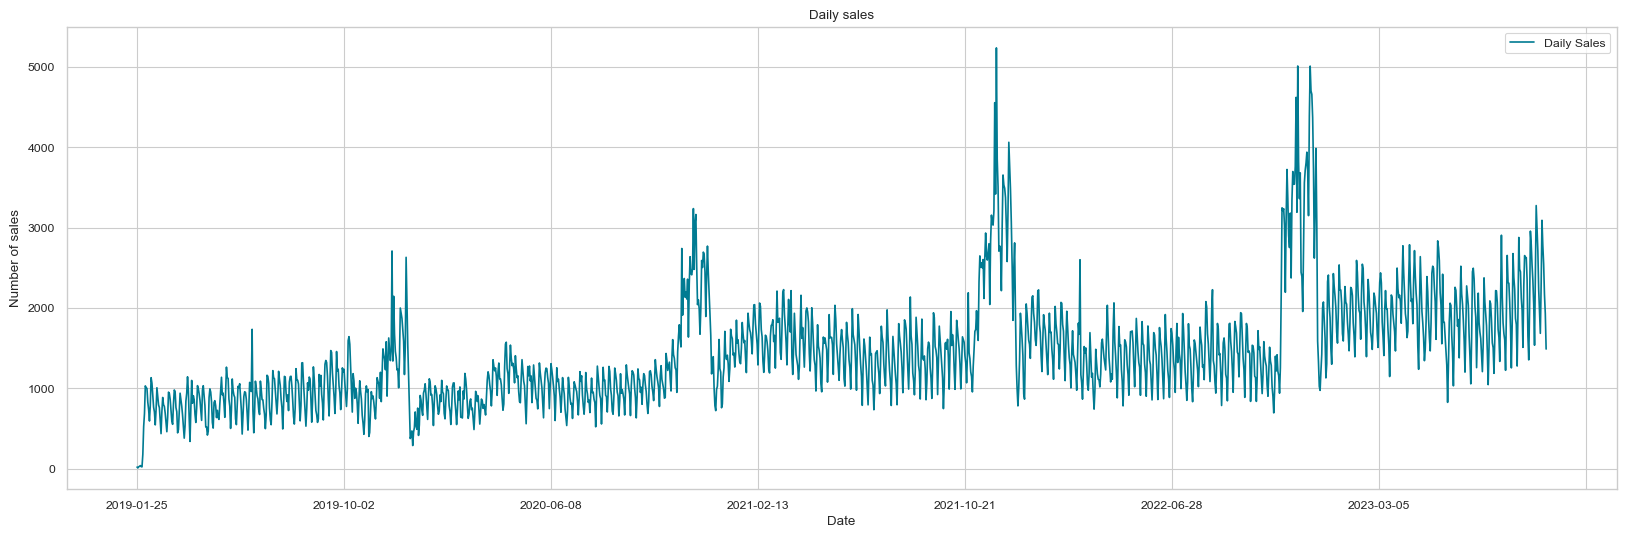

In [75]:
plt.figure(figsize=(20, 6))
daily_sales.plot(label='Daily Sales')
plt.title('Daily sales')
plt.xlabel('Date')
plt.ylabel('Number of sales')
plt.legend()
plt.show()

`TimeseriesGenerator` is a utility class in Keras that helps in creating sequences of time series data for training machine learning models

In [76]:
# get all targets y from a TimeseriesGenerator instance.
def get_y_from_generator(gen):
    y = None
    for i in range(len(gen)): # Loop over all batches
        batch_y = gen[i][1] # Extract target values (y) from batch
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

(1703, 1)


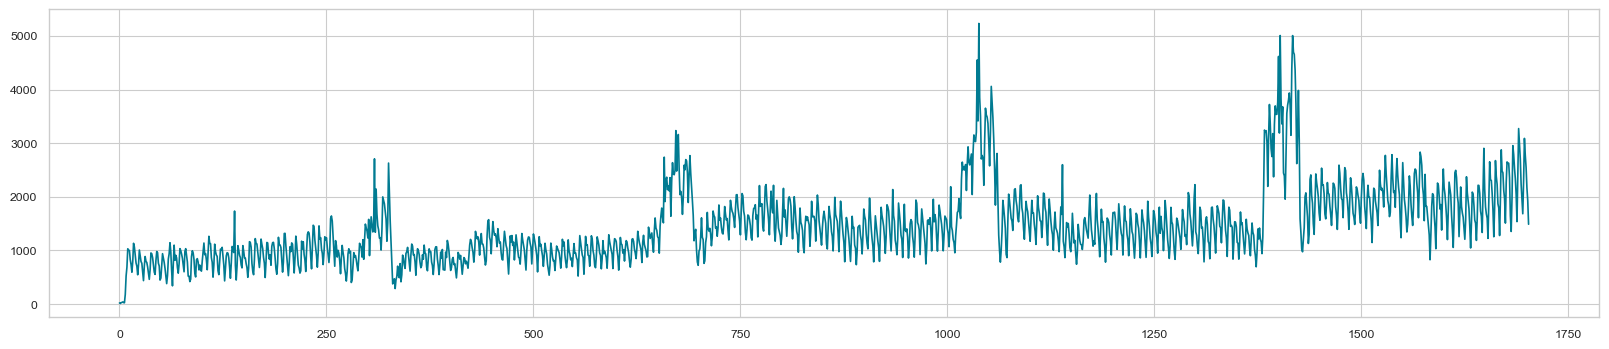

In [77]:
y = daily_sales.values #Extracts the values from the daily_sales
x = np.arange(0, y.size, 1) # Creates a sequence of numbers for plotting

data = y.reshape(-1,1)
print(data.shape)
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(data)
plt.show()

# Clean data

**The Augmented Dickey-Fuller (ADF)** test is a `statistical test` used to determine whether a time series is stationary (it has a constant mean and variance over time). Non-stationary data can lead to inaccurate predictions. A low p-value (<0.05) means the data is stationary, while a high value suggests it needs transformation before applying predictive models.

**Seasonal-Trend Decomposition (STL)** is a technique used to separate a time series into its trend, seasonality, and residual components. Removing the seasonal component can improve forecasting performance. In this case, STL helps extract the trend from our noisy time series, focus on the underlying long-term pattern making it easier to analyze and model 

STL separates time series into:
 - trend (long-term movement)
 - seasonality (repeating patterns)
 - residual (random noise)

	1. ADF :  -3.7958301004648356
	2. P-Value :  0.002950267818796576
	3. Num Of Lags :  25


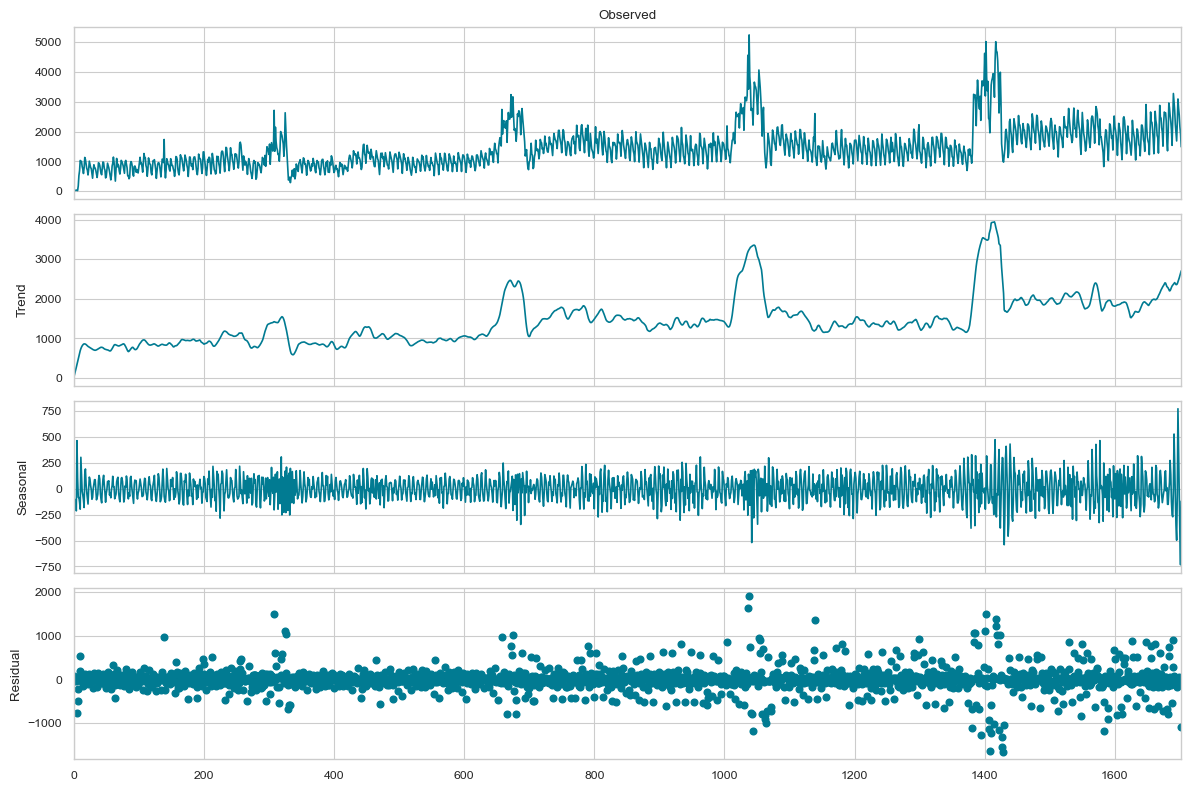

In [78]:
dftest = adfuller(data, autolag = 'AIC') # Perform ADF test to check for stationarity
print("\t1. ADF : ",dftest[0]) # Test statistic (should be negative)
print("\t2. P-Value : ", dftest[1]) # P-value (should be < 0.05 for stationarity)
print("\t3. Num Of Lags : ", dftest[2])
          
result = STL(data, period=6, robust = True).fit() # Apply STL decomposition
plt.rcParams["figure.figsize"] = (12,8)
result.plot()
plt.show()

# Different options for cleaning data
# data_cleaned = result.trend 
# data_cleaned = result.trend + result.seasonal 
data_cleaned = result.trend + result.seasonal + result.resid     # all data without cleaning / default choice

data_cleaned = data_cleaned.flatten().reshape(-1, 1)

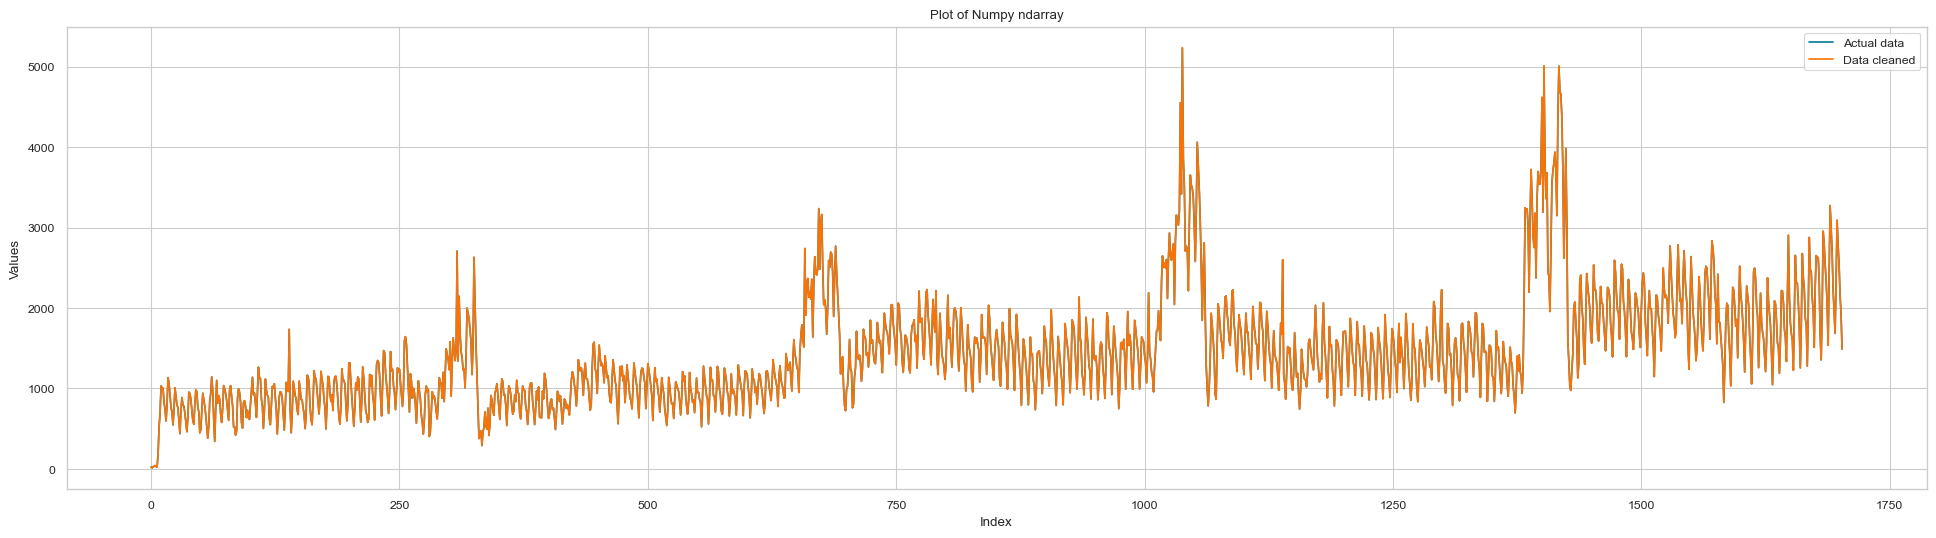

In [79]:
# Plot all columns in 'data_cleaned'
# You won't see difference if you chose default clean_data
plt.figure(figsize=(24, 6))
plt.plot(y)
plt.plot(data_cleaned)
plt.title('Plot of Numpy ndarray')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend(['Actual data', 'Data cleaned'])
plt.show()

# Training

When training machine learning models, it is essential to track training progress, performance metrics, and potential issues. `Logging` helps in debugging, experiment management, and optimizing hyperparameters efficiently

`Weights & Biases (WandB)` is an experiment tracking and model management tool designed for machine learning (ML) and deep learning projects

In [80]:
import os
import wandb
import logging
# Create logging 
logging.basicConfig(filename="training_log.log",
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

os.environ["WANDB_SILENT"] = "true"   # silence WANDB init as it gets a bit annoying with bigger trainings

wandb.login() # The terminal will ask for your API key (found at wandb.ai)

True

### Hyper-parameter tuning with wandb (Weights & Biases)

Defining a custom Keras callback to integrate Weights & Biases (WandB) into a deep learning training loop. The callback automatically logs training metrics after each epoch

In [81]:
from tensorflow.keras.callbacks import Callback

class WandbCallback(Callback):
    def __init__(self, config):
        super().__init__() # Initialize parent class (Callback)
        self.config = config # Store configuration for later use

    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs, step=epoch) # Send logs to WandB, using epoch as the step


In [82]:
def hyperparameter_tune(config: dict):
  #using hyperparameters from the config dictionary
    run_name = f"train-lr{config['lr']}-ep{config['epochs']}-bs{config['batch_size']}-lu{config['lstm_units']}-lb{config['lookback']}-oa{config['output_activation']}"

    #Initializes a WandB run to track model performance
    wandb.init(
            project="dp_lstm",
            config=config,
            name=run_name
        )
    
    #normalize the data to improve the stability and efficiency
    scaler = MinMaxScaler(feature_range=(0, 1)) # Scale data between 0 and 1
    data_trans = scaler.fit_transform(data_cleaned)

    #split the dataset into 80% training and 20% testing
    train_size = int(len(data_trans) * 0.80)
    test_size = len(data_trans) - train_size
    train, test = data_trans[0:train_size,:], data_trans[train_size:len(data_trans),:]

    look_back = config["lookback"]#determines how many past time steps are used to predict the next value
    train_data_gen = TimeseriesGenerator(train, 
                                         train,
                                         length=look_back, 
                                         sampling_rate=1,
                                         stride=1,
                                         batch_size=config["batch_size"]
                                        )
    test_data_gen = TimeseriesGenerator(test, 
                                        test,
                                        length=look_back, 
                                        sampling_rate=1,
                                        stride=1,
                                        batch_size=config["batch_size"]
                                       )

    # model
    x = Input(shape=(look_back, 1))
    h = LSTM(units=config["lstm_units"])(x)   
    y = Dense(units=1, activation=config["output_activation"])(h)
    model = Model(inputs=x, outputs=y)
    #print(model.summary())
    
    # compile model
    opt = Adam(learning_rate=config['lr'])
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])
    
    wandb_callback = WandbCallback(config)# WandB callback for tracking metrics
    model.fit(train_data_gen, epochs=config["epochs"], shuffle=True, callbacks=[wandb_callback])
    
    return model.evaluate(test_data_gen)

We can perform hyperparameter tuning by iterating over different combinations of hyperparameters and training an LSTM model with each configuration. However, we can also skip this process since it takes a long time.

By default, the best-performing hyperparameter combination found during the tuning process is stored below

In [83]:
# WANDB HYPERPARAMETER TUNE, change the next line to True to use it 
wandb_tuning = False

# Dictionary containing different hyperparameter values for tuning
config = {"lr": [0.1, 0.01, 0.001],
          "epochs": [5, 10, 20, 30, 50],
          "batch_size": [1, 3, 5, 8],
          "lstm_units": [3, 5, 7, 10],
          "lookback": [7, 10, 14],
          "output_activation": ['linear', 'sigmoid']
         }

# If hyperparameter tuning is enabled (wandb_tuning=True), the script will execute the loop below
if wandb_tuning:
    %%capture --no-stdout
    test_config = {}
    
    for lr in config["lr"]:
        test_config["lr"] = lr
        for epch in config["epochs"]:
            test_config["epochs"] = epch
            for bs in config["batch_size"]:
                test_config["batch_size"] = bs
                for lstm_u in config["lstm_units"]:
                    test_config["lstm_units"] = lstm_u
                    for lckb in config["lookback"]:
                        test_config["lookback"] = lckb
                        for outa in config["output_activation"]:
                            test_config["output_activation"] = outa

                            logging.info(f"Training - {test_config}")
                            res = hyperparameter_tune(test_config)
                            logging.info(f"Results - (loss, mse, mae): {res}")

In [84]:
# BEST ACHIEVED RESULT 
BR_config = {'lr': 0.01, 'epochs': 30, 'batch_size': 1, 'lstm_units': 5, 'lookback': 10, 'output_activation': 'linear'}

# Visualize best results for sale trend prediction

We are repeating the data preparation and model creation steps because we are now using the best-performing hyperparameters `BR_config` to train the final model and visualize its predictions

In [85]:
scaler = MinMaxScaler(feature_range=(0, 1)) # Scale data between 0 and 1
data_trans = scaler.fit_transform(data_cleaned)

#split the dataset into 80% training and 20% testing
train_size = int(len(data_trans) * 0.80)
test_size = len(data_trans) - train_size
train, test = data_trans[0:train_size,:], data_trans[train_size:len(data_trans),:]

#determines how many past time steps are used to predict the next value
look_back = BR_config["lookback"]
train_data_gen = TimeseriesGenerator(train, 
                                     train,
                                     length=look_back, 
                                     sampling_rate=1,
                                     stride=1,
                                     batch_size=BR_config["batch_size"]
                                    )
test_data_gen = TimeseriesGenerator(test, 
                                    test,
                                    length=look_back, 
                                    sampling_rate=1,
                                    stride=1,
                                    batch_size=BR_config["batch_size"]
                                   )
                                   
# model
x = Input(shape=(look_back, 1))
h = LSTM(units=BR_config["lstm_units"])(x) 
y = Dense(units=1, activation=BR_config["output_activation"])(h)

model = Model(inputs=x, outputs=y)
print(model.summary())

# compile model
opt = Adam(learning_rate=BR_config['lr'])
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])
model.fit(train_data_gen, epochs=BR_config["epochs"], shuffle=True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5)              │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146 (584.00 B)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
  50/1352 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0128 - mae: 0.0931 - mse: 0.0128

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1352/1352 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0059 - mae: 0.0591 - mse: 0.0059
Epoch 2/30
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0037 - mae: 0.0457 - mse: 0.0037
Epoch 3/30
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0030 - mae: 0.0400 - mse: 0.0030
Epoch 4/30
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0029 - mae: 0.0365 - mse: 0.0029
Epoch 5/30
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0030 - mae: 0.0371 - mse: 0.0030
Epoch 6/30
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0023 - mae: 0.0344 - mse: 0.0023
Epoch 7/30
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0021 - mae: 0.0330 - mse: 0.0021
Epoch 8/30
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0025 - mae: 0.0353 - mse: 0.0025
Epoch 9/30
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0022 - mae: 0.0323 - mse: 0.0022
Epoch 10/30
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0020 - mae: 0.0320 - mse: 0.0020
Epoch 11/30
1352/1352 ━━━━━━━━━━━━━━━━━━

In [86]:
model.evaluate(test_data_gen)

331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0064 - mae: 0.0558 - mse: 0.0064


[0.00410098023712635, 0.00410098023712635, 0.04653435945510864]

In [87]:
trainPredict = model.predict(train_data_gen)
print(trainPredict.shape)
testPredict = model.predict(test_data_gen)
print(testPredict.shape)

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
(1352, 1)
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(331, 1)


We obtained the predicted values; however, since the model was trained on scaled data, we need to reverse the MinMax scaling to restore the data to its original scale for accurate evaluation and real-world interpretation.

In [88]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [89]:
# get from the TimeseriesGenerator to compare against predicted values
trainY = get_y_from_generator(train_data_gen) 
testY = get_y_from_generator(test_data_gen)

(1352, 1)
(331, 1)


In [90]:
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

## Model evaluation

As we can see, the model has a higher error on unseen data, which likely indicates potential overfitting.

In [91]:
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 203.09 RMSE
Test Score: 334.41 RMSE


## Plotting

Analyzing how well the LSTM model performs on train data

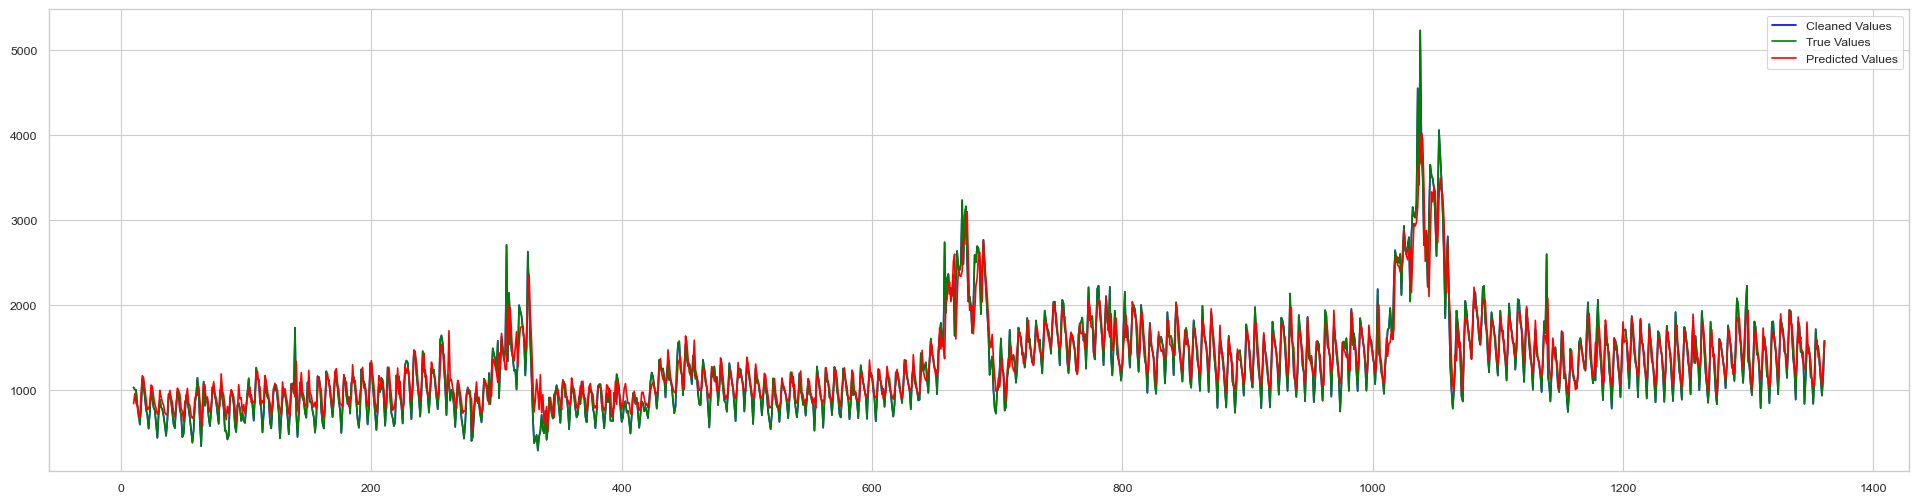

In [92]:
begin =  look_back
end = begin + len(trainPredict)

trainYPlot = np.empty_like(data, dtype=float)  # Ensure dtype is float
trainYPlot[:, :] = np.nan
trainYPlot[begin:end, :] = trainY

trainPredictPlot = np.empty_like(data, dtype=float)  # Ensure dtype is float
trainPredictPlot[:, :] = np.nan
trainPredictPlot[begin:end, :] = trainPredict

trainTruePlot = np.empty_like(data, dtype=float)  # Ensure dtype is float
trainTruePlot[:, :] = np.nan
trainTruePlot[begin:end, :] = data[look_back:len(trainY)+look_back]

# Plot baseline and predictions
plt.figure(figsize=(24, 6))  # Adjusted figure size
#plt.plot(data_org, label='Original Data') # Uncomment if original raw data needs to be plotted
plt.plot(trainYPlot, label='Cleaned Values', color='blue')
plt.plot(trainTruePlot, label='True Values', color='green')
plt.plot(trainPredictPlot, label='Predicted Values', color='red')

plt.legend()
plt.show()

Analyzing how well the LSTM model performs on test data

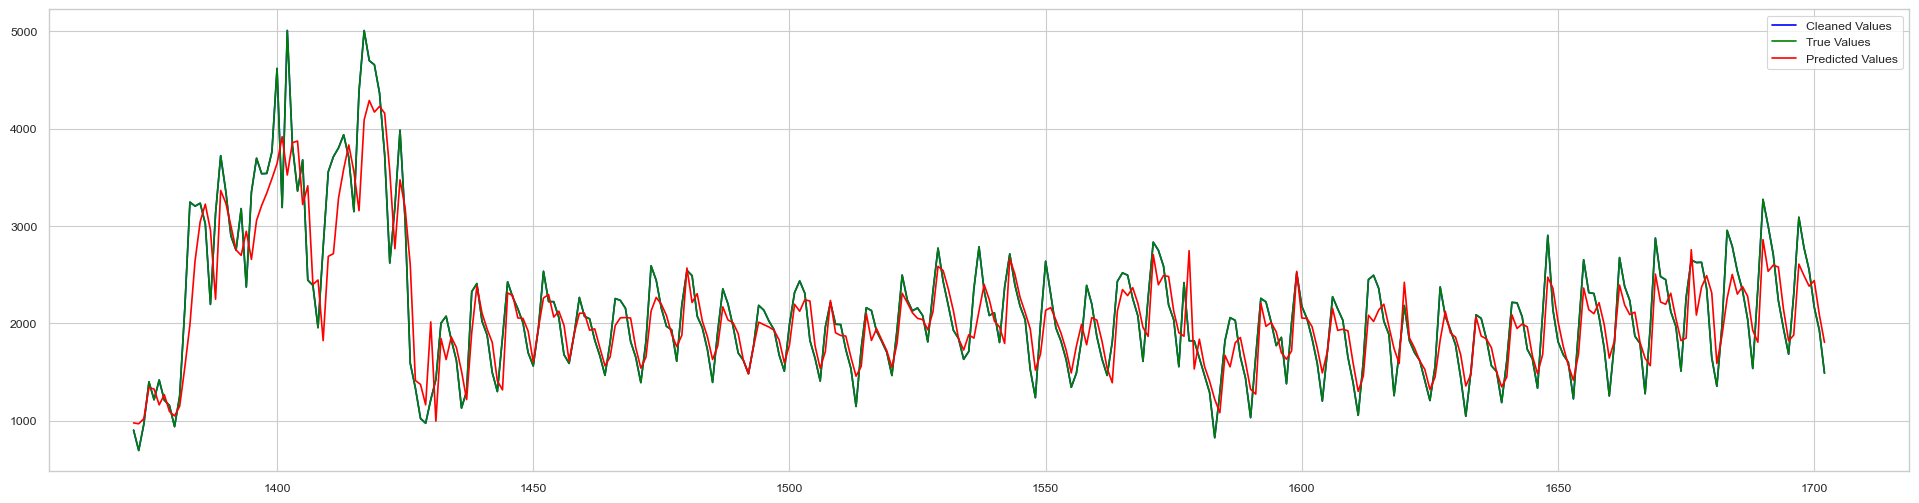

In [93]:
begin = train_size + look_back
end = begin + len(testPredict)

testYPlot = np.empty_like(data, dtype=float)  # Ensure dtype is float
testYPlot[:, :] = np.nan
testYPlot[begin:end, :] = testY

testPredictPlot = np.empty_like(data, dtype=float)  # Ensure dtype is float
testPredictPlot[:, :] = np.nan
testPredictPlot[begin:end, :] = testPredict

testTruePlot = np.empty_like(data, dtype=float)  # Ensure dtype is float
testTruePlot[:, :] = np.nan
testTruePlot[begin:end, :] = data[-len(testY):]

# Plot baseline and predictions
plt.figure(figsize=(24, 6))  # Adjusted figure size
#plt.plot(data_org, label='Original Data')
plt.plot(testYPlot, label='Cleaned Values', color='blue')
plt.plot(testTruePlot, label='True Values', color='green')
plt.plot(testPredictPlot, label='Predicted Values', color='red')


plt.legend()  
plt.show()

We can see the model generalizes well to unseen data and captures overall trends. However, it has trouble predicting sharp peaks and sometimes lags behind, which might mean it is overfitting or needs better tuning.